Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6850 - loss: 0.8931 - val_accuracy: 0.7716 - val_loss: 0.6032
Epoch 2/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7592 - loss: 0.6435 - val_accuracy: 0.7818 - val_loss: 0.5655
Epoch 3/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7700 - loss: 0.6063 - val_accuracy: 0.7907 - val_loss: 0.5437
Epoch 4/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7759 - loss: 0.5872 - val_accuracy: 0.7893 - val_loss: 0.5313
Epoch 5/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7826 - loss: 0.5668 - val_accuracy: 0.7929 - val_loss: 0.5215
Epoch 6/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7846 - loss: 0.5589 - val_accuracy: 0.7939 - val_loss: 0.5115
Epoch 7/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7859 - loss: 0.5461 - val_accuracy: 0.7972 - val_loss: 0.5069
Epoch 8/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7874 - loss: 0.5409 - val

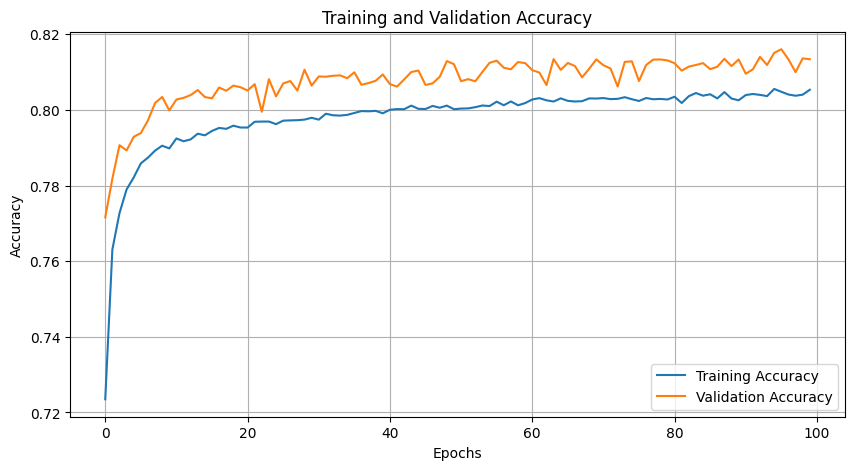

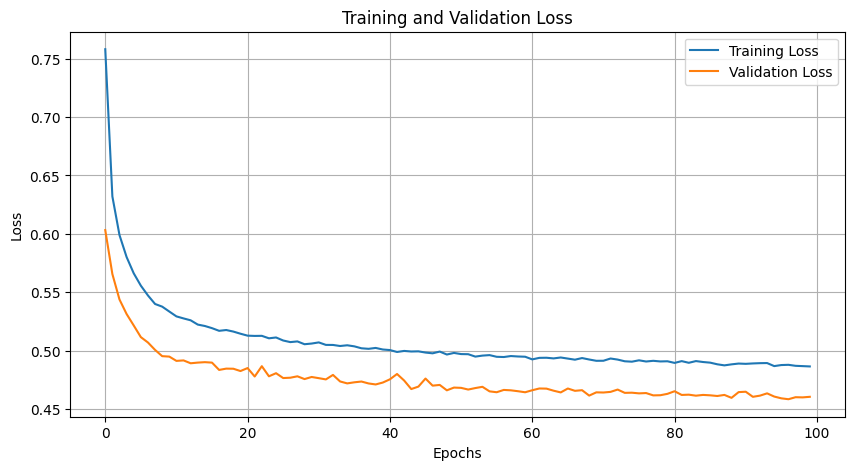

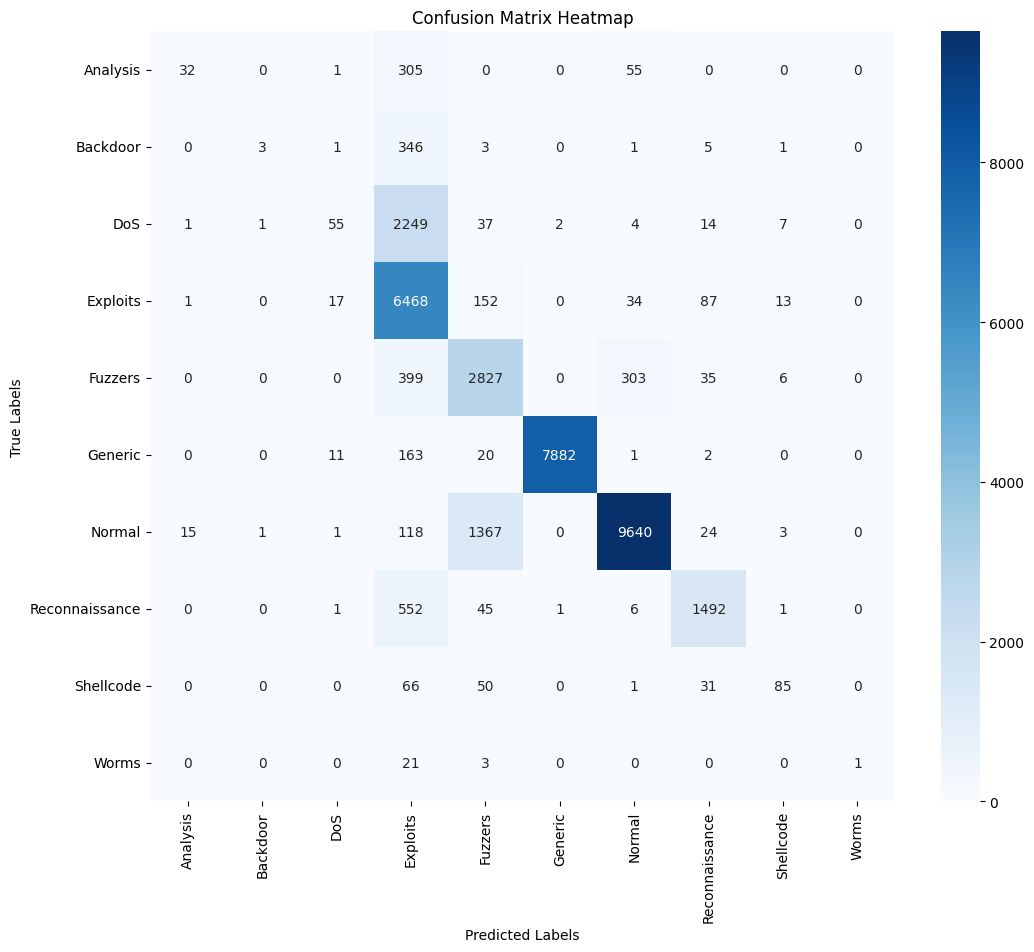

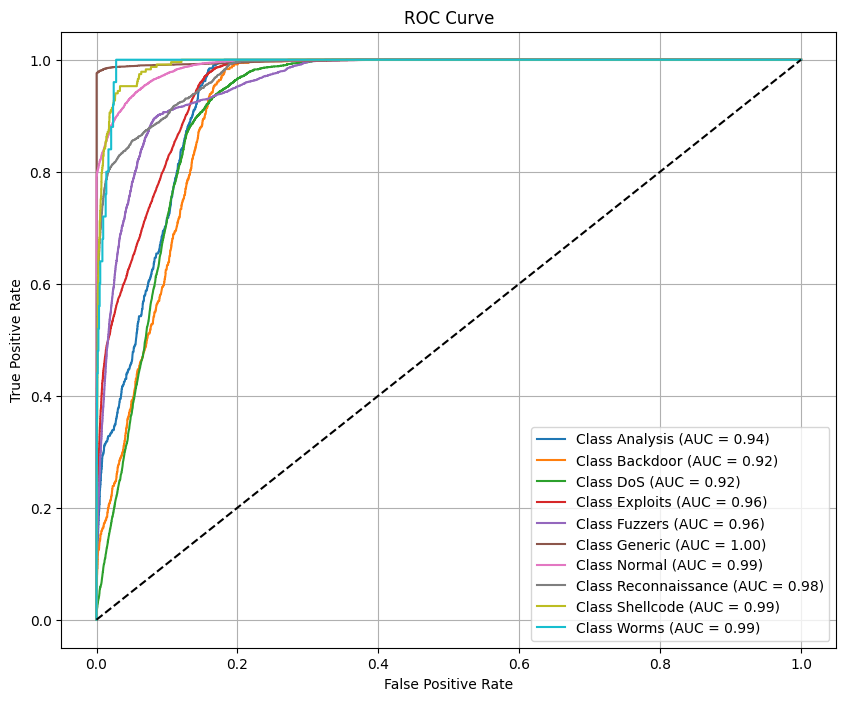

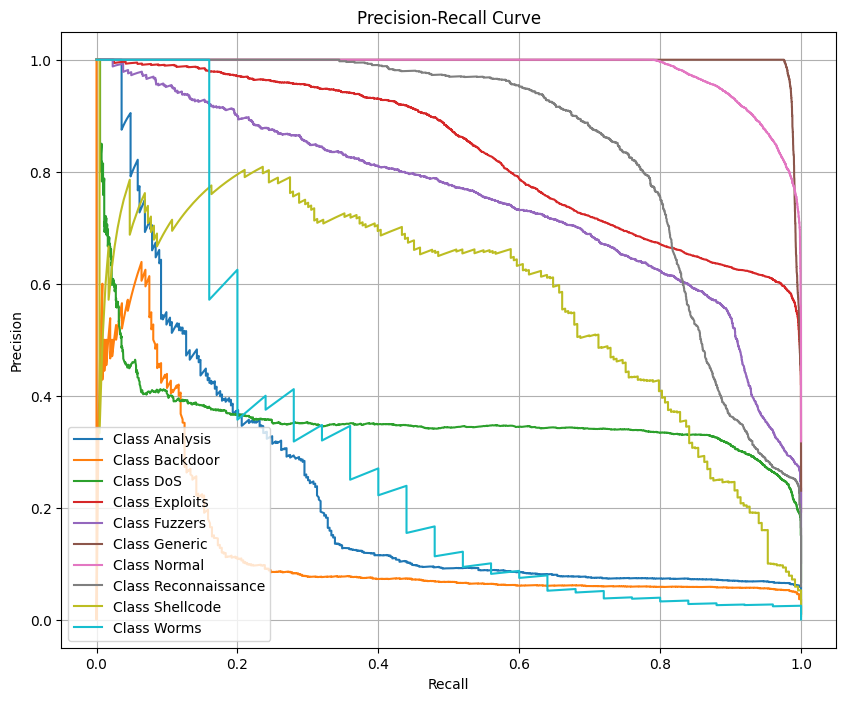

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("SENG 4610 Training Data.csv")
data = data.drop(['id'], axis=1)

# Encode categorical columns
categorical_columns = ['proto', 'service', 'state', 'attack_cat']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

attack_labels = label_encoders['attack_cat'].classes_

# Features and target
X = data.drop(['label', 'attack_cat'], axis=1)
y = data['attack_cat']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode the target labels
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Neural Network Model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)
model.save('finalmodel.keras')

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Map predictions and true values back to labels
y_pred_labels = [attack_labels[pred] for pred in y_pred_classes]
y_true_labels = [attack_labels[true] for true in y_true]

print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, labels=attack_labels, zero_division=0))

print("Confusion Matrix:\n")
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels, labels=attack_labels)

# Accuracy and Loss Visualization
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=attack_labels, yticklabels=attack_labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC Curve
from sklearn.preprocessing import label_binarize

y_true_binarized = label_binarize(y_true, classes=range(len(attack_labels)))

plt.figure(figsize=(10, 8))
for i in range(len(attack_labels)):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {attack_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i in range(len(attack_labels)):
    precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], y_pred[:, i])
    plt.plot(recall, precision, label=f'Class {attack_labels[i]}')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import tensorflow as tf

# Save trained model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved in both .keras and .tflite formats for deployment.")

Saved artifact at '/tmp/tmp8ryim77_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='keras_tensor_18')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138979327118496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138979325980944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138979325974784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138979325977776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138979325979008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138979325979536: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model saved in both .keras and .tflite formats for deployment.
